# Идея

todo

In [1]:
# TODO: n предыдущих состояний -- в env и wrapper (для state и F) -- done
# TODO: CE хаки
# TODO: обучать по случайным состояниям
# TODO: тренировать по части истории (рандомно (и последовательно?))
# TODO: добавить шум при обучении к предыдущим x

In [2]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [3]:
from ddpg_agent import Agent

### Env

In [4]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
n_steps=100
t_min=0
t_max=10

t0 = 0
n_prev = 3
n_prev_f = 3
t_step = 0.3
n_steps = 100

delta = beta / (2 * m)
omega_0 = k / m

In [5]:
def x_force(t):
    if t <= 0:
        return 1
    return np.exp(-t * 0.05)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     x_force=x_force, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * x_force(t0)
        )
        t0 += step
    return res

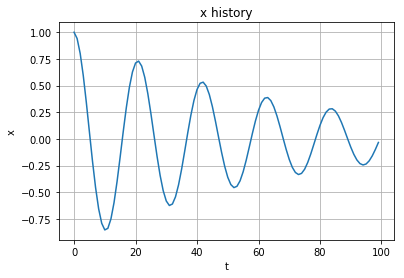

In [6]:
history = generate_history(t0, t_step, n_steps)
plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [7]:
class SimpleModel(gym.Env):
    
    def __init__(self, history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev):
        self._history = history
        self._n_prev = n_prev
        self._big_f_0 = big_f_0
        self._k = k

        self._n_prev = n_prev
        self._i = n_prev - 1
        self._last_x = deque(self._history[:self._n_prev])
        self._t0 = t0
        self.t_step = t_step
        self.t = self._t0 + (n_prev - 1) * self.t_step
        self._n_steps = n_steps
        
        self.observation_space = spaces.Box(low=-100, high=100, shape=(n_prev,), dtype=np.float32)
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)
 
        
    def _x_model(self, m, delta, big_omega):
        """Returns the model position."""
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        return big_b * np.cos(big_omega * self.t - theta)
    
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        f_0 = self._big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res
    
    def step(self, action):

        # step
        self._i += 1
        self.t += self.t_step

        # reward
        m_, delta_, big_omega_ = action[0], action[1], action[2]
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        x_ = self._x_model(m_, delta_, big_omega_)
        reward = - (x_ - self._history[self._i]) ** 2

        # done
        done = self._i >= self._n_steps - 1
        
        # info
        info = {}
        
        # obs
        self._last_x.popleft()
        self._last_x.append(x_)
        obs = np.array(self._last_x)
        np.expand_dims(obs, axis=1)
        
        return obs, reward, done, info
    
    def reset(self):
        self._i = self._n_prev - 1
        self.t = self._t0 + (n_prev - 1) * self.t_step
        self._last_x = deque(self._history[:self._n_prev])
        obs = np.array(self._last_x)
        np.expand_dims(obs, axis=1)
        return obs
    
    def render(self):
        pass

    

In [8]:
class ForceWrapper(gym.ObservationWrapper):
    
    def __init__(self, env, force_func=x_force, n_prev_f=n_prev_f):
        super().__init__(env)
        print(env.t_step)
        self._n_prev_f = n_prev_f
        self.force_func = force_func
        self.observation_space = spaces.Box(
            low=-100, high=100, shape=(self.env.observation_space.shape[0] + self._n_prev_f,), dtype=np.float32)
        
    def step(self, action):
        o, r, d, info =  self.env.step(action)
        o = np.hstack([o, self._get_f()])
        return o, r, d, info
        
    def reset(self):
        o = self.env.reset()
        o = np.hstack([o, self._get_f()])
        return o
    
    def _get_f(self):
        return [self.force_func(self.env.t - self.env.t_step * i) for i in range(self._n_prev_f, 0, -1)]

In [9]:
class NoiseWrapper(gym.ObservationWrapper):
    
    def __init__(self, env, scale=0.1):
        super().__init__(env)
        self._scale = scale
    
    def step(self, action):
        o, r, d, info =  self.env.step(action)
        return o + self._get_noise(), r, d, info
        
    def reset(self):
        o = self.env.reset()
        return o + self._get_noise()
    
    def _get_noise(self):
        return np.random.normal(scale=self._scale, size=(self.observation_space.shape))

# Some tests

In [10]:
history = generate_history(t0, t_step, n_steps, x_force=lambda t: 1)
env = SimpleModel(history, t0, t_step, n_steps)

In [11]:
for i in range(20):
    env.reset()
    o, r, d, _ = env.step([m, delta, big_omega])
    assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([m, delta, big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

reset_1 = env.reset()
for i in range(3):
    o, r, d, _ = env.step([0.1, 0.1, 0.1])
reset_2 = env.reset()
assert np.all(reset_1 == reset_2)

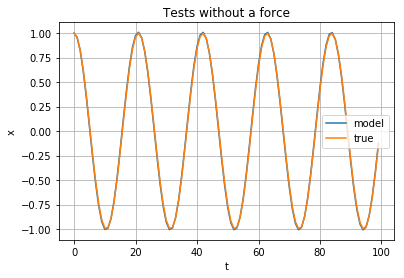

In [12]:
points = list(env.reset())
points += [env.step([m, delta, big_omega])[0][-1] for _ in range(len(history) - env._n_prev)]
points = np.array(points).reshape((-1,))

assert len(points) == len(history)
for p, h in zip(*(points, history)):
    pass
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [13]:
history = generate_history(t0, t_step, n_steps, x_force=x_force)
env = SimpleModel(history, t0, t_step, n_steps)
env = ForceWrapper(env, x_force)

0.3


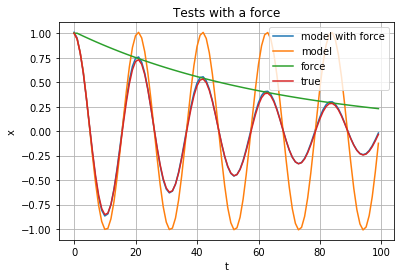

In [14]:
o = list(env.reset())
points = o[:n_prev]
forces = o[n_prev:]

for _ in range(len(history) - n_prev):
    o = env.step([m, delta, big_omega])[0]
    points.append(o[n_prev-1:n_prev])
    forces.append(o[-1])

points = np.array(points)
forces = np.array(forces)

# assert points.shape == forces.shape
plt.plot(points*forces + 0.01, label="model with force")
plt.plot(points, label="model")
plt.plot(forces, label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# CE

from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb

In [15]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [16]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# env.seed(101)
# np.random.seed(101)

# print('observation space:', env.observation_space)
# print('action space:', env.action_space)
# print('  - low:', env.action_space.low)
# print('  - high:', env.action_space.high)

# class Agent(nn.Module):
#     def __init__(self, env, h_size=16):
#         super(Agent, self).__init__()
#         self.env = env
#         # state, hidden layer, action sizes
#         self.s_size = env.observation_space.shape[0]
#         self.h_size = h_size
#         self.a_size = env.action_space.shape[0]
#         # define layers
#         self.fc1 = nn.Linear(self.s_size, self.h_size)
#         self.fc2 = nn.Linear(self.h_size, self.a_size)
        
#     def set_weights(self, weights):
#         s_size = self.s_size
#         h_size = self.h_size
#         a_size = self.a_size
#         # separate the weights for each layer
#         fc1_end = (s_size*h_size)+h_size
#         fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
#         fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
#         fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
#         fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
#         # set the weights for each layer
#         self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
#         self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
#         self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
#         self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
#     def get_weights_dim(self):
#         return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = torch.tanh(self.fc2(x))
#         return x.cpu().data
        
#     def evaluate(self, weights, gamma=1.0, max_t=5000):
#         self.set_weights(weights)
#         episode_return = 0.0
#         state = self.env.reset()
#         for t in range(max_t):
#             state = torch.from_numpy(state).float().to(device)
#             action = self.forward(state)
#             state, reward, done, _ = self.env.step(action.numpy())
#             episode_return += reward * math.pow(gamma, t)
#             if done:
#                 break
#         return episode_return
    
# agent = Agent(env).to(device)

In [17]:


class Agent(nn.Module):
    def __init__(self, env, h1_size=16, h2_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h1_size = h1_size
        self.h2_size = h2_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h1_size)
        self.fc2 = nn.Linear(self.h1_size, self.h2_size)
        self.fc3 = nn.Linear(self.h2_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h1_size = self.h1_size
        h2_size = self.h2_size
        a_size = self.a_size
        
        # separate the weights for each layer
        fc1_end = (s_size * h1_size) + h1_size
        fc2_end = fc1_end + (h1_size * h2_size) + h2_size
        
        fc1_W = torch.from_numpy(weights[:s_size*h1_size].reshape(s_size, h1_size))
        fc1_b = torch.from_numpy(weights[s_size*h1_size:fc1_end])
        
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + h1_size * h2_size].reshape(h1_size, h2_size))
        fc2_b = torch.from_numpy(weights[fc1_end + h1_size * h2_size:fc2_end])
        
        fc3_W = torch.from_numpy(weights[fc2_end:fc2_end+(h2_size*a_size)].reshape(h2_size, a_size))
        fc3_b = torch.from_numpy(weights[fc2_end+(h2_size*a_size):])
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        self.fc3.weight.data.copy_(fc3_W.view_as(self.fc3.weight.data))
        self.fc3.bias.data.copy_(fc3_b.view_as(self.fc3.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h1_size + (self.h1_size+1)*self.h2_size + (self.h2_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action.numpy())
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

In [18]:
def plot_result(env, agent):
    s = env.reset()
    d = False
    points = [s[0]]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(agent(state).numpy())
        s, r, d, _ = env.step(a)
        points.append(s[0])

    plt.plot(points, label="model")
    plt.plot(history, label="true")
    plt.title("CE training")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

In [19]:
def cem(plot_env, n_iterations=1800, max_t=1000, gamma=1.0, print_every=50, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(0, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            plot_result(plot_env, agent)

        if np.mean(scores_deque)>=-0.1:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores


In [20]:
history = generate_history(t0, t_step, n_steps)

env_train = SimpleModel(history, t0, t_step, n_steps)
env_train = ForceWrapper(env_train, x_force)
env_train = NoiseWrapper(env_train, 15)

env_test = SimpleModel(history, t0, t_step, n_steps)
env_test = ForceWrapper(env_test, x_force)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_train.seed(101)
env_test.seed(101)
np.random.seed(101)

print('observation space:', env_train.observation_space)
print('action space:', env_train.action_space)
print('  - low:', env_train.action_space.low)
print('  - high:', env_train.action_space.high)

0.3
0.3
observation space: Box(6,)
action space: Box(3,)
  - low: [ 0.  -2.  -0.1]
  - high: [10.   2.   0.1]


/home/dev/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Could not seed environment <SimpleModel instance>
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [21]:
# agent = Agent(env_train, h_size=64).to(device)
# scores = cem(plot_env=env_test)

# # plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.title('Score')
# plt.show()

In [22]:
# load the weights from file
# agent.load_state_dict(torch.load('checkpoint.pth'))

# plot_result(env, agent)

# Random Training

In [23]:
# TODO: обучение по части истории (как времянные ряды)
class SimpleTrainModel(SimpleModel):
    
    def __init__(self, history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev,
                 n_random_steps=100):
        SimpleModel.__init__(self, history, t0, t_step, n_steps, big_f_0, k, n_prev)
        self._n_r_steps = n_random_steps
        self._i_r = 0
        self._set_random_x()
    
    def _set_random_x(self):
        self._i = np.random.randint(self._n_prev, self._n_steps)
        self._x_prev = self._history[self._i - self._n_prev:self._i]
        self._x = self._history[self._i]
        self.t = self._t0 + self._i * t_step
        
        
    def step(self, action):

        # reward
        m_, delta_, big_omega_ = action[0], action[1], action[2]
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        x_ = self._x_model(m_, delta_, big_omega_)
        reward = - ((x_ - self._x) * 100) ** 2

        # done
        self._i_r += 1
        done = self._i_r == self._n_r_steps
        
        # info
        info = {}
        
        # obs
        self._set_random_x()
        obs = np.array(self._x_prev)
        np.expand_dims(obs, axis=1)
        
        return obs, reward, done, info
    
    def reset(self):
        self._i_r = 0
        self._set_random_x()
        obs = np.array(self._x_prev)
        np.expand_dims(obs, axis=1)
        return obs
    

In [24]:
env_random_train = SimpleTrainModel(history)
env_random_train = NoiseWrapper(env_random_train)
env_random_train = ForceWrapper(env_random_train)

0.3


In [25]:
env_random_train.reset()
env_random_train.step([1,2,3])

(array([-0.23292835,  0.01153485, -0.12604742,  0.31505754,  0.31036694,
         0.30574618]), -1680.3289392586687, False, {})

Episode 0	Average Score: -168618.88


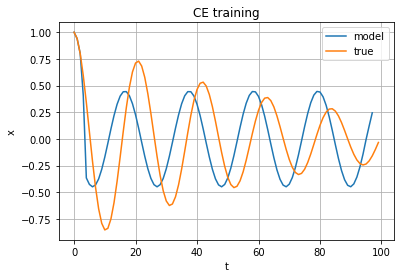

Episode 50	Average Score: -166700.98


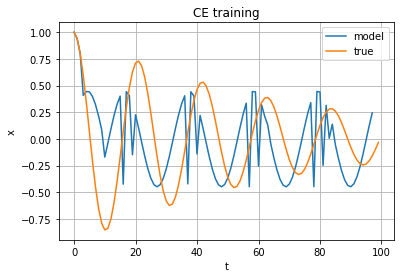

Episode 100	Average Score: -141309.01


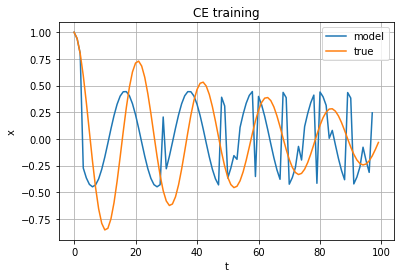

Episode 150	Average Score: -137573.36


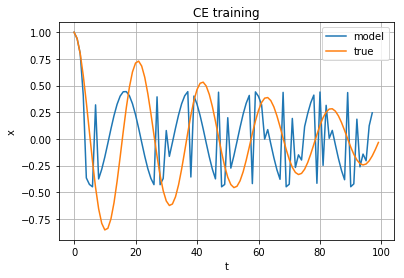

Episode 200	Average Score: -133103.51


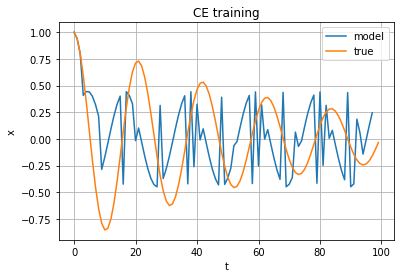

Episode 250	Average Score: -108272.60


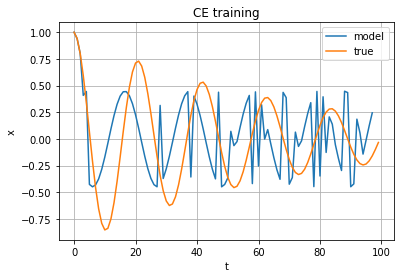

Episode 300	Average Score: -106588.34


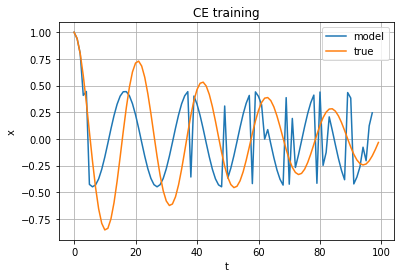

Episode 350	Average Score: -101699.05


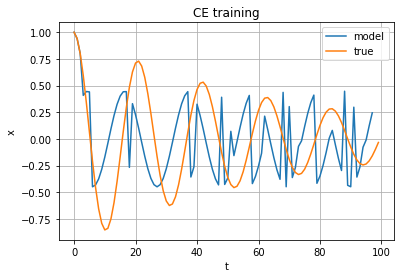

Episode 400	Average Score: -101104.96


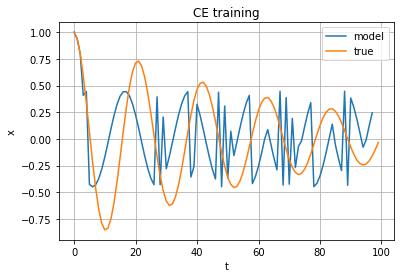

Episode 450	Average Score: -102262.77


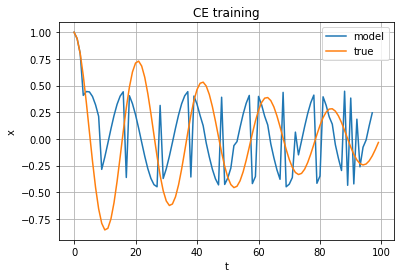

Episode 500	Average Score: -102606.94


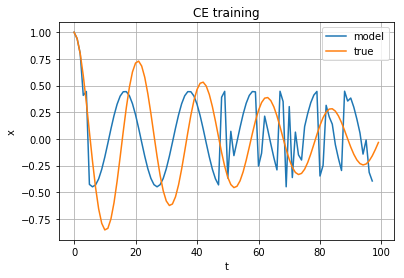

Episode 550	Average Score: -104387.28


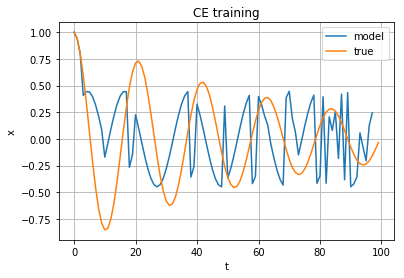

Episode 600	Average Score: -108175.70


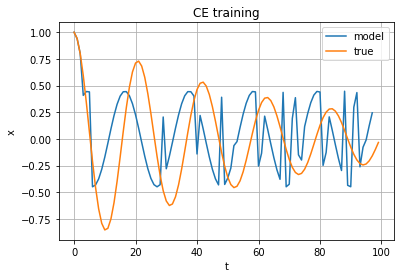

Episode 650	Average Score: -109445.83


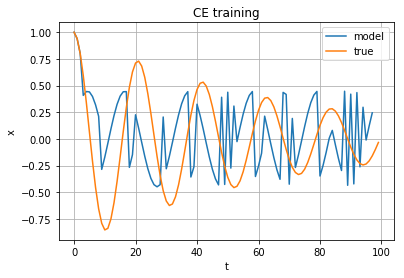

Episode 700	Average Score: -109003.53


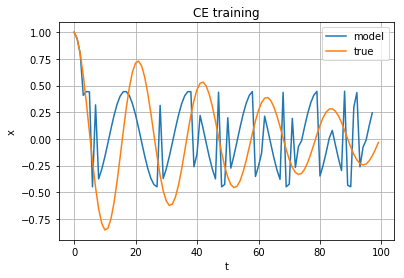

Episode 750	Average Score: -107765.63


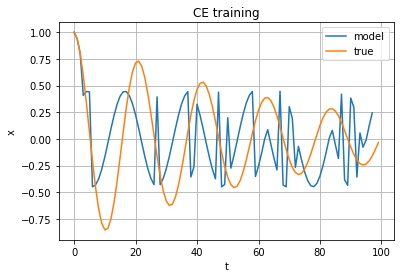

Episode 800	Average Score: -105509.95


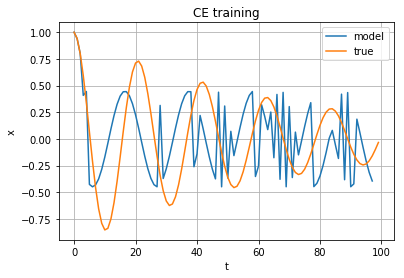

Episode 850	Average Score: -106494.48


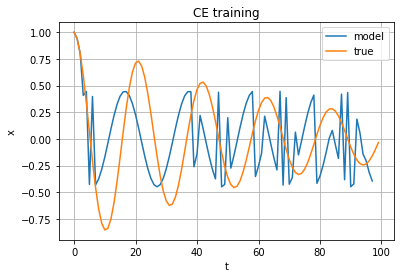

Episode 900	Average Score: -106960.38


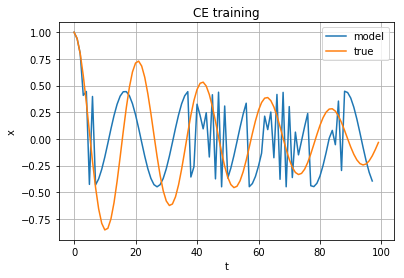

Episode 950	Average Score: -103662.86


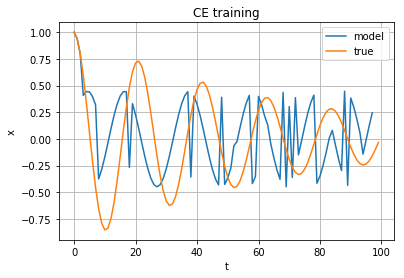

Episode 1000	Average Score: -102732.66


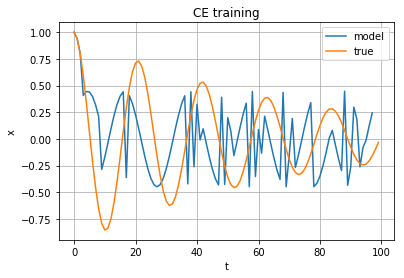

Episode 1050	Average Score: -102598.98


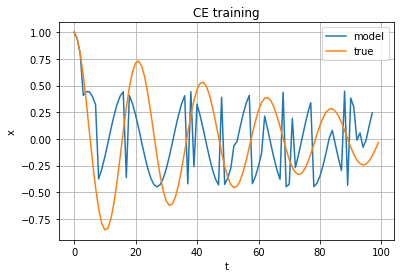

Episode 1100	Average Score: -99002.84


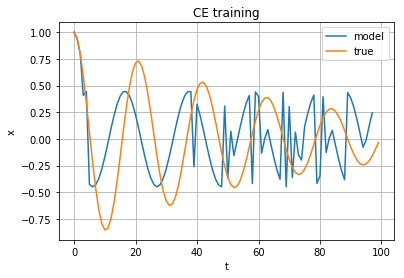

Episode 1150	Average Score: -97583.08


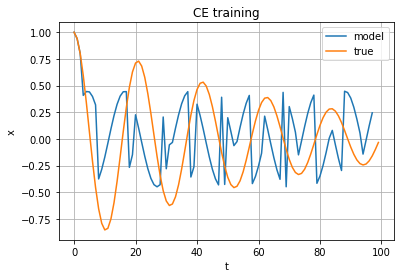

Episode 1200	Average Score: -99785.61


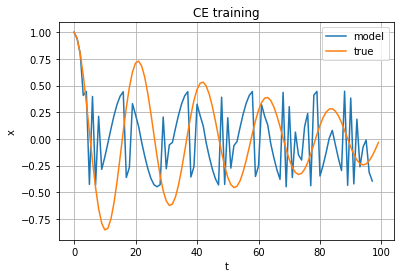

Episode 1250	Average Score: -103178.11


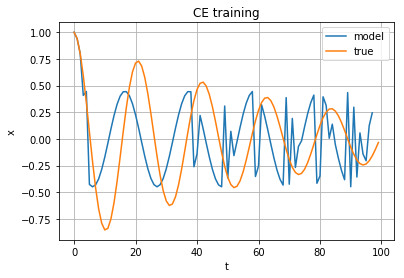

Episode 1300	Average Score: -104315.26


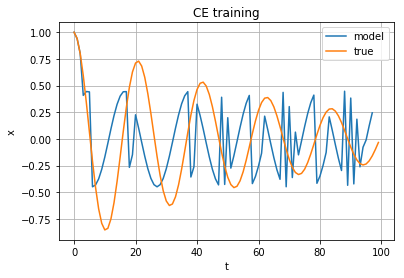

Episode 1350	Average Score: -102653.46


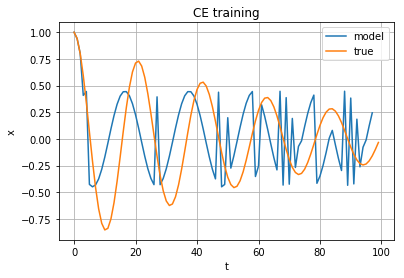

Episode 1400	Average Score: -102625.67


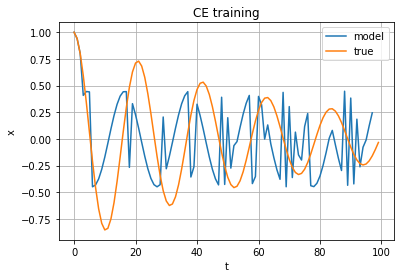

Episode 1450	Average Score: -103594.06


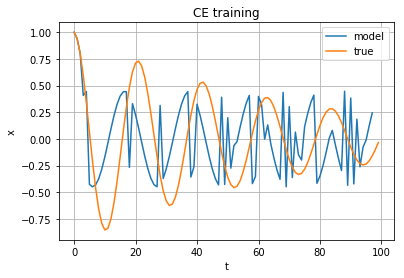

Episode 1500	Average Score: -101784.20


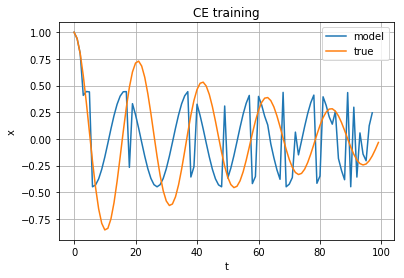

Episode 1550	Average Score: -98500.22


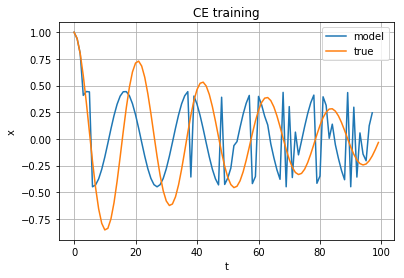

Episode 1600	Average Score: -97000.20


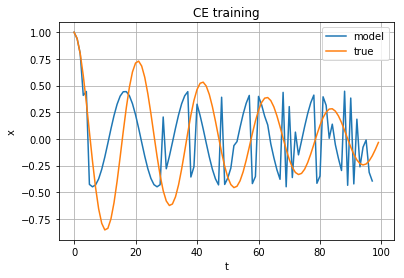

Episode 1650	Average Score: -96601.01


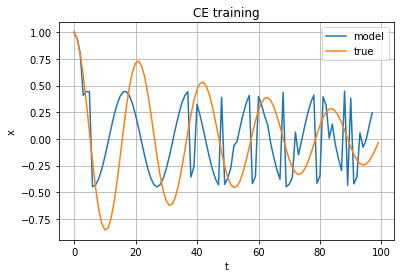

Episode 1700	Average Score: -95908.32


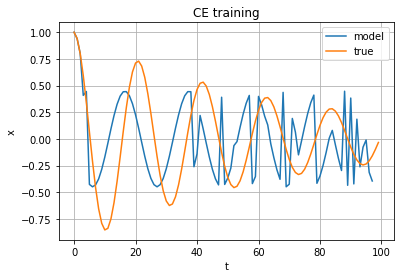

Episode 1750	Average Score: -95692.56


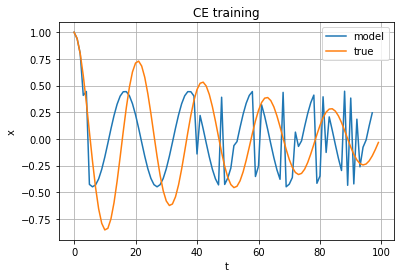

Episode 1800	Average Score: -96618.44


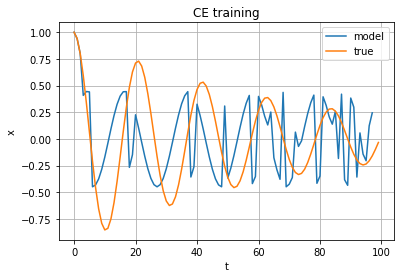

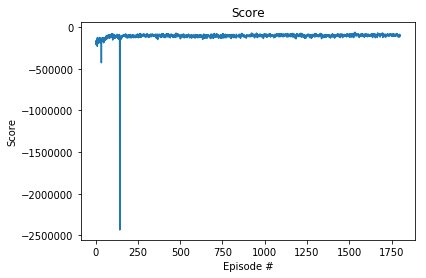

In [26]:
agent = Agent(env_random_train, h1_size=16, h2_size=16).to(device)
scores = cem(plot_env=env_test, sigma=2, elite_frac=0.1, gamma=0.8)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score')
plt.show()

In [27]:
# добать две картинки -- plot random env true предыдущим состояниям и plot картинку в начале

In [ ]:
# вернуться к исходному варианту